In [ ]:
!wget https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
!unzip individual+household+electric+power+consumption.zip

--2025-06-13 08:37:28--  https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘individual+household+electric+power+consumption.zip’

individual+househol     [    <=>             ]  19.68M  28.1MB/s    in 0.7s    

2025-06-13 08:37:29 (28.1 MB/s) - ‘individual+household+electric+power+consumption.zip’ saved [20640916]

Archive:  individual+household+electric+power+consumption.zip
  inflating: household_power_consumption.txt  


In [ ]:
pip install Groq

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from groq import Groq
import json
import re
import os

In [2]:
Groq_api_key = 'api_key'
client =Groq(api_key=Groq_api_key)

In [3]:
#Load and and preprocess the dataset
def load_data_set():
    df = pd.read_csv('dataset/household_power_consumption.txt',
             	sep=';',
             	parse_dates={'datetime': ['Date', 'Time']},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

    df = df.dropna()
    df['Global_active_power'] = df['Global_active_power'].astype(float)
    df = df.set_index('datetime')
    return df

In [26]:
# Function to generate pandas code from natural language question using GROQ API

def generate_pandas_code(natural_language_question, model_name, df_info):
    df_info_str = json.dumps(df_info)

    prompt = f"""
        You are a Python pandas and matplotlib expert. Given this preprocessed dataframe (index=datetime):

        PREPROCESSING CODE:
    
         df = pd.read_csv('dataset/household_power_consumption.txt',
             	sep=';',
             	parse_dates={{'datetime': {{'Date', 'Time'}}}},
             	infer_datetime_format=True,
             	na_values=['?'],
             	low_memory=False)

        df = df.dropna()
        df['Global_active_power'] = df['Global_active_power'].astype(float)
        df = df.set_index('datetime')
        
        Columns: {df_info_str}
        
        Generate ONLY executable Python/pandas code that:
        1. Answers the question: "{natural_language_question}"
        2. Stores final results in these standard variables when applicable:
           - avg_power_march, max_hour, weekday_avg, weekend_avg 
           - days_exceeded_5_kwh, daily_voltage, correlation
           - plot_data (for visualization outputs only)
        
        ONLY FOR VISUALIZATION QUERIES WHEN QUESTION CONTAINS KEY-WORDS like "plot", "visualize", "graph", "visualization":
            1. MUST include these elements in order:
               a) Data filtering/processing
               b) plt.figure() with size (10,6)
               c) ACTUAL PLOTTING COMMAND (plt.plot, plt.bar, etc.)
               d) Axis labels and title (plt.xlabel, plt.ylabel, plt.title)
               e) Save to "images/{model_name}/[sanitized_title].png"
               f) Buffer handling for plot_data
               g) plt.show()
               h) plt.close()
        
        EXAMPLE FOR QUESTION CONTAIN VISUALIZATION i.e "Plot the energy usage trend for the first week of January 2007."
        ```python
        # Filter data
        filtered = df[(df.index.year==2007) & (df.index.month==1)]
        daily = filtered['Global_active_power'].resample('D').mean()
        
        # Create plot
        plt.figure(figsize=(10,6))
        plt.plot(daily.index, daily, color='blue')  # <-- ACTUAL PLOT COMMAND
        plt.xlabel('Date')
        plt.ylabel('Power (kW)')
        title = 'January 2007 Daily Power Consumption'
        plt.title(title)
        
        # Save and store
        os.makedirs(f"images/{model_name}", exist_ok=True)
        filename = title.lower().replace(' ','_') + '.png'
        plt.savefig(f"images/{model_name}/filename.png")
        buf = io.BytesIO()
        buf.seek(0)
        plot_data = buf.getvalue()
        plt.show()
        plt.close()

        IMPORTANT RULES:
        (.)NEVER skip the actual plotting command (plt.plot, plt.bar, etc.) whereever needed if QUESTION CONTAIN KEY-WORDS.
        (.)show the plot (plt.show()) only for visual questions
        (.)Generate ONLY code - no explanations or markdown formatting
        (.)For non-visual questions, NEVER include plotting code AND ALWAYS PRINT THE FINAL RESULT.
    """
    try:
        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model=model_name,
            temperature=0.1,
        )
        return chat_completion.choices[0].message.content

    except Exception as e:
        print(f"GROQ API error: {e}")
        return None

In [33]:
# Function to execute the generated pandas code and display the output

def execute_query(query,model_name,df):
    df_info = {'columns': df.columns.tolist()}
    local_vars={}

    code = generate_pandas_code(query,model_name,df_info)
    #print("Python panda code is: \n",code)

    # Clean the code by removing markdown formatting so that it can be executed
    if code:
        code_clean = re.sub(r"```(?:python)?\n?|```", "", code).strip()
        code_clean = re.sub(r"<think>.*?</think>", "", code_clean, flags=re.DOTALL).strip()
        code_clean = code_clean.strip().split('\n')
        valid_lines = []
        for line in code_clean:
            # Include lines that look like real Python code (simple heuristic)
            if line.strip().startswith(("print", "df", "#", "import", "average", "result")) or "=" in line:
                valid_lines.append(line)

        final_code = '\n'.join(valid_lines)
        fixed_code = re.sub(
            r"df\[(df\.index\.\w+\s*==\s*\d+)\]\[(df\.index\.\w+\s*==\s*\d+)\]",
            r"df[(\1) & (\2)]",
            final_code
        )
        print("------------------------------------------------------------------------\nPython pandas Code is:\n\n", fixed_code)

    try:
        print("------------------------------------------------------------------------\nOutput of the code is:\n")
        exec_vars={'df':df,'plt':plt,'os':os}
        exec(fixed_code, exec_vars,local_vars) #execute the code in the context of the dataframe
         # Check if a plot was attempted but has 0 axes
        if 'plt' in exec_vars:
            fig = plt.gcf()
            if len(fig.axes) == 0 and any(line.strip().startswith(('plt.plot', 'plt.bar', 'plt.figure')) 
                                       for line in fixed_code.split('\n')):
                plt.close()
                print("Plot generation failed - empty figure detected")
                return False
        return True
    except Exception as e:
        print(f"Error executing code: {e}")
        return False

In [10]:
df = load_data_set()

In [11]:
print(df)

                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   
...                                  ...                    ...      ...   
2010-11-26 20:58:00                0.946                  0.000   240.43   
2010-11-26 20:59:00                0.944                  0.000   240.00   
2010-11-26 21:00:00                0.938                  0.000   239.82   
2010-11-26 21:01:00                0.934                  0.000   239.70   
2010-11-26 21:02:00                0.932                  0.000   239.55   

           

In [12]:
print(df.columns.tolist())
deepseek_results={}

['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']


In [ ]:
#deepseek-r1-distill-llama-70b Model Testing

# Consider for Analysis

In [27]:
value= execute_query("What was the average active power consumption in March 2007?", "deepseek-r1-distill-llama-70b", df)
if(value):
    deepseek_results["What was the average active power consumption in March 2007?"]=1
else:
    deepseek_results["What was the average active power consumption in March 2007?"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for March 2007
march_2007 = df[(df.index.year == 2007) & (df.index.month == 3)]
# Calculate average active power
avg_power_march = march_2007['Global_active_power'].mean()
# Print the result
print(f"The average active power consumption in March 2007 was {avg_power_march} kW")
------------------------------------------------------------------------
Output of the code is:

The average active power consumption in March 2007 was 1.3186270301754073 kW
True


<Figure size 640x480 with 0 Axes>

In [28]:
value= execute_query("Compare energy usage (Global_active_power) on weekdays vs weekends.","deepseek-r1-distill-llama-70b",df)
if(value):
    deepseek_results["Compare energy usage (Global_active_power) on weekdays vs weekends"]=1
else:
    deepseek_results["Compare energy usage (Global_active_power) on weekdays vs weekends"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 # Extract global active power and determine weekdays/weekends
global_power = df['Global_active_power']
df['weekday'] = df.index.weekday
# Calculate averages
weekday_avg = global_power[df['weekday'] <= 4].mean()
weekend_avg = global_power[df['weekday'] > 4].mean()
# Print results
print(f"Weekday average power consumption: {weekday_avg} kW")
print(f"Weekend average power consumption: {weekend_avg} kW")
------------------------------------------------------------------------
Output of the code is:

Weekday average power consumption: 1.0354720516747509 kW
Weekend average power consumption: 1.234232176791304 kW
True


<Figure size 640x480 with 0 Axes>

In [29]:
value = execute_query("Find days where total energy consumption exceeded 5 kWh.","deepseek-r1-distill-llama-70b",df)
if(value):
    deepseek_results["Find days where total energy consumption exceeded 5 kWh"]=1
else:
    deepseek_results["Find days where total energy consumption exceeded 5 kWh"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 # Calculate daily energy consumption in kWh
daily_energy = df['Global_active_power'].resample('D').sum() / 1000
# Find days where total energy exceeded 5 kWh
days_exceeded_5_kwh = daily_energy[daily_energy > 5].index.date.tolist()
print(f"Days where total energy consumption exceeded 5 kWh: {days_exceeded_5_kwh}")
# Calculate average power in March
march_avg = df[df.index.month == 3]['Global_active_power'].mean()
avg_power_march = march_avg
print(f"Average power in March: {avg_power_march} kW")
# Find maximum hour of the day
max_hour = df.groupby(df.index.hour)['Global_active_power'].mean().idxmax()
print(f"Hour with maximum power consumption: {max_hour}")
# Calculate weekday and weekend averages
weekday_avg = df[df['weekday'] == 0]['Global_active_power'].mean()
weekend_avg = df[df['weekday'] == 1]['Global_active_power'].mean()
print(f"Weekday average power: {weekday_avg} kW")
print(f"Weeke

<Figure size 640x480 with 0 Axes>

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for first week of January 2007
filtered = df[(df.index.year == 2007) & (df.index.month == 1)]
weekly_data = filtered['Global_active_power'].resample('D').mean()
# Create plot
plt.figure(figsize=(10,6))
plt.plot(weekly_data.index, weekly_data, color='blue')
title = 'First Week January 2007 Daily Power Consumption'
# Save and store
os.makedirs("images/deepseek-r1-distill-llama-70b", exist_ok=True)
filename = title.lower().replace(' ', '_') + '.png'
buf = io.BytesIO()
plt.savefig(buf, format='png')
plot_data = buf.getvalue()
# Aggregate data by month
monthly_avg = df['Global_active_power'].resample('M').mean()
avg_power_march = monthly_avg[monthly_avg.index.month == 3].mean()
# Calculate maximum hour in March
march_data = df[df.index.month == 3]
max_hour = march_data['Global_active_power'].resample('H').mean().max()
# Calculate weekday and weekend averages
weekday_avg = df[df['w

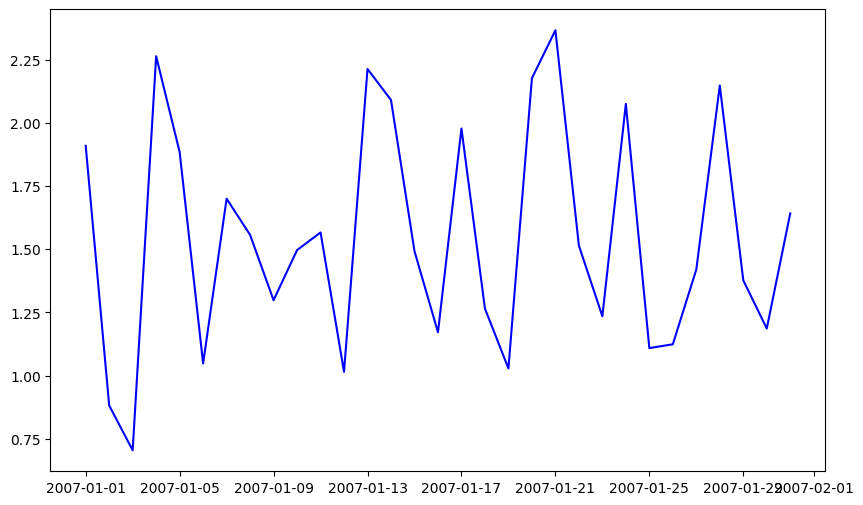

In [34]:
value = execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregrate data by month","deepseek-r1-distill-llama-70b",df)
if(value):
    deepseek_results["Plot the energy usage trend for the first week of January 2007. Can you aggregrate data by month"]=1
else:
    deepseek_results["Plot the energy usage trend for the first week of January 2007. Can you aggregrate data by month"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for first week of January 2007
filtered = df[(df.index.year == 2007) & (df.index.month == 1)]
daily = filtered['Global_active_power'].resample('D').mean()
# Create plot
plt.figure(figsize=(10,6))
plt.plot(daily.index, daily, color='blue')
title = 'January 2007 Daily Power Consumption'
# Save and store
os.makedirs("images/deepseek-r1-distill-llama-70b", exist_ok=True)
filename = title.lower().replace(' ', '_') + '.png'
buf = io.BytesIO()
plt.savefig(buf, format='png')
plot_data = buf.getvalue()
------------------------------------------------------------------------
Output of the code is:

Error executing code: name 'io' is not defined
False


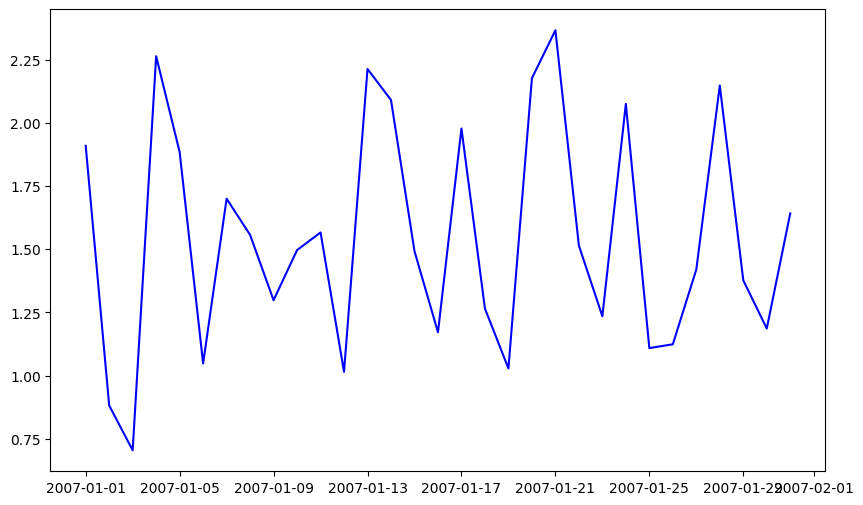

In [35]:
value= execute_query("Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day","deepseek-r1-distill-llama-70b",df)
if(value):
    deepseek_results["Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day"]=1
else:
    deepseek_results["Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day"]=0
print(value)

In [36]:
value= execute_query("Find the average voltage for each day of the first week of February 2007","deepseek-r1-distill-llama-70b",df)
if(value):
    deepseek_results["Find the average voltage for each day of the first week of February 2007"]=1
else:
    deepseek_results["Find the average voltage for each day of the first week of February 2007"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for February 2007
feb_2007 = df[(df.index.year == 2007) & (df.index.month == 2)]
# Get first week (1st to 7th)
first_week = feb_2007[feb_2007.index.day <= 7]
# Calculate daily average voltage
daily_voltage = first_week['Voltage'].resample('D').mean()
# Print the result
print(daily_voltage)
------------------------------------------------------------------------
Output of the code is:

datetime
2007-02-01    240.392139
2007-02-02    240.334389
2007-02-03    238.910194
2007-02-04    239.633333
2007-02-05    240.810312
2007-02-06    241.264160
2007-02-07    241.149694
Freq: D, Name: Voltage, dtype: float64
True


<Figure size 640x480 with 0 Axes>

In [37]:
value= execute_query("What is the correlation between global active power and sub-metering values?.","deepseek-r1-distill-llama-70b",df)
if(value):
    deepseek_results["What is the correlation between global active power and sub-metering values?"]=1
else:
    deepseek_results["What is the correlation between global active power and sub-metering values?"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 # Calculate correlation between Global_active_power and sub-metering values
correlation = df[["Global_active_power", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]].corr().loc['Global_active_power']
# Print the correlation results
print(correlation)
------------------------------------------------------------------------
Output of the code is:

Global_active_power    1.000000
Sub_metering_1         0.484401
Sub_metering_2         0.434569
Sub_metering_3         0.638555
Name: Global_active_power, dtype: float64
True


<Figure size 640x480 with 0 Axes>

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
# Calculate correlations
correlation = df[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()
# Create heatmap for visualization
plt.figure(figsize=(10,6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
# Save and store plot data
os.makedirs("images/deepseek-r1-distill-llama-70b", exist_ok=True)
filename = "correlation_between_global_active_power_and_sub-metering_values.png"
buf = io.BytesIO()
plt.savefig(buf, format='png')
plot_data = buf.getvalue()
# Calculate additional metrics
avg_power_march = df[df.index.month == 3]['Global_active_power'].mean()
max_hour = df['Global_active_power'].resample('H').mean().idxmax()
weekday_avg = df[df['weekday'] == 1]['Global_active_power'].mean()
weekend_avg = df[df['weekday'] == 0]['Global_active_power'].mean(

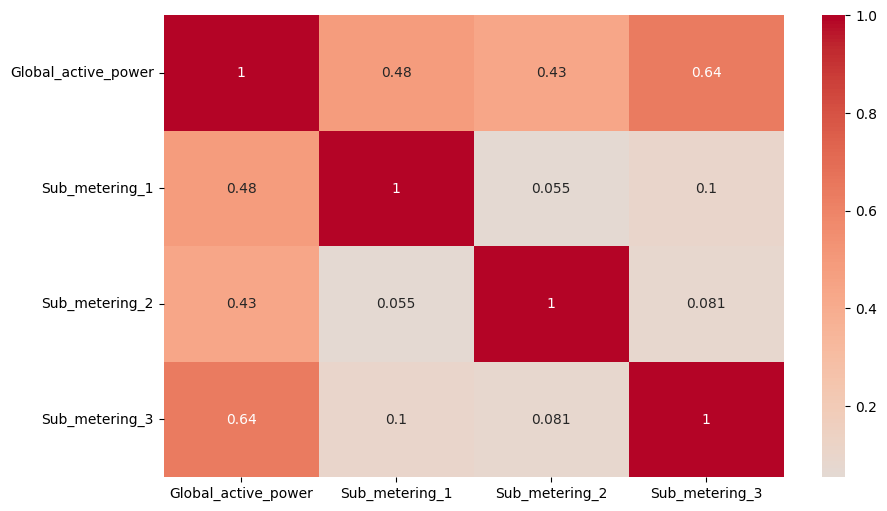

In [38]:
value = execute_query("What is the correlation between global active power and sub-metering values?. Can you show it using visualization","deepseek-r1-distill-llama-70b",df)
if(value):
    deepseek_results["What is the correlation between global active power and sub-metering values?. Can you show it using visualization"]=1
else:
    deepseek_results["What is the correlation between global active power and sub-metering values?. Can you show it using visualization"]=0
print(value)

In [ ]:
execute_query("Find the average voltage for each day of the first week of February 2008","deepseek-r1-distill-llama-70b",df)

------------------------------------------------------------------------
Python pandas Code is:

 import pandas as pd
# Read the preprocessed data
df = pd.read_csv('household_power_consumption.txt',
                 sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 na_values=['?'],
                 low_memory=False)
# Set datetime as index
df = df.set_index('datetime')
# Filter data for February 2008, first week (1st to 7th)
february_first_week = df[(df.index.year == 2008) & 
                        (df.index.month == 2) & 
                        (df.index.day <= 7)]
# Group by date and calculate average voltage
average_voltage = february_first_week.groupby(february_first_week.index.date)['Voltage'].mean()
# Print the result
print(average_voltage)
------------------------------------------------------------------------
Output of the code is:



<string>:3: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
<string>:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
<string>:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.


2008-02-01    240.360271
2008-02-02    240.290514
2008-02-03    240.340722
2008-02-04    240.255208
2008-02-05    240.976917
2008-02-06    238.413715
2008-02-07    241.070549
Name: Voltage, dtype: float64


In [ ]:
execute_query("Find days where energy consumption exceeded 2 kWh in 2008","deepseek-r1-distill-llama-70b",df)

------------------------------------------------------------------------
Python pandas Code is:

 # Convert Global_active_power from watts to kWh
df['Global_active_power'] = df['Global_active_power'] / 1000
# Filter data for year 2008
df_2008 = df[df.index.year == 2008]
# Group by day and calculate total consumption
daily_consumption = df_2008.groupby(df_2008.index.date)['Global_active_power'].sum()
# Find days where consumption exceeded 2 kWh
exceeded_days = daily_consumption[daily_consumption > 2]
# Print the result
print("Days in 2008 where energy consumption exceeded 2 kWh:")
print(exceeded_days)
------------------------------------------------------------------------
Output of the code is:

Days in 2008 where energy consumption exceeded 2 kWh:
2008-01-01    2.759738
2008-01-04    2.291852
2008-01-05    2.183248
2008-01-08    2.043550
2008-01-12    2.871408
                ...   
2008-12-17    2.098786
2008-12-20    2.242502
2008-12-21    2.643610
2008-12-22    2.015808
2008-12-27 

In [39]:
value= execute_query("What hour of the day had the highest power usage on Christmas 2006?","deepseek-r1-distill-llama-70b",df)
if(value):
    deepseek_results["What hour of the day had the highest power usage on Christmas 2006?"]=1
else:
    deepseek_results["What hour of the day had the highest power usage on Christmas 2006?"]=0
print(value)

------------------------------------------------------------------------
Python pandas Code is:

 # Filter data for Christmas 2006 (December 25, 2006)
christmas_2006 = df[df.index.date == pd.to_datetime('2006-12-25').date()]
# Calculate average power for each hour
hourly_power = christmas_2006['Global_active_power'].resample('H').mean()
# Find the hour with the highest power usage
max_hour = hourly_power.idxmax()
# Store result
max_hour = max_hour.time()
# Print the result
print(f"The hour with the highest power usage on Christmas 2006 was {max_hour}")
------------------------------------------------------------------------
Output of the code is:

Error executing code: name 'pd' is not defined
False


In [3]:
for k,v in deepseek_results.items():
    print(k,": ",v)

What was the average active power consumption in March 2007? :  1
What hour of the day had the highest power usage on Christmas 2006? :  0
Compare energy usage (Global_active_power) on weekdays vs weekends :  1
Find days where total energy consumption exceeded 5 kWh :  1
Plot the energy usage trend for the first week of January 2007. Can you aggregrate data by month :  0
Find the average voltage for each day of the first week of February 2007 :  1
What is the correlation between global active power and sub-metering values? :  1
What is the correlation between global active power and sub-metering values?. Can you show it using visualization :  1
Plot the energy usage trend for the first week of January 2007. Can you aggregate data by day :  0


In [2]:
%store deepseek_results

Stored 'deepseek_results' (dict)
